# Lab Tutorial 04 (Solved)

- **Module:** Computer Vision - IN3060/INM460
- **Module leader:** [Giacomo Tarroni](mailto:giacomo.tarroni@city.ac.uk)

# Google Colab Setup
Before starting the tutorial, we need to run a few commands to set up our environment on Google Colab. To this end, make sure to have first gone through the **"Software setup guide"** document uploaded on Moodle. Also, if you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store the lab materials for this tutorial!), and follow the instructions.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded the lab materials, fill it in below and run the cell:

In [2]:
import os

# TODO: Fill in the Google Drive path where you uploaded the lab materials
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Lab materials 01-20210104'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision lab tutorials/Lab 04' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['OnTheBeach.png', 'GroundTruth.png', 'Lab_04_Solved.ipynb', 'Lab_04.ipynb']


If everything is working correctly then running the folowing cell should print the filenames from the lab materials folder:

```
['OnTheBeach.png', 'GroundTruth.png', 'Lab_04_Solved.ipynb', 'Lab_04.ipynb']
```

# Introduction

In this lab tutorial, we will learn how to perform **image segmentation**. As discussed in the lecture, image segmentation **partitions an image into multiple regions**.

# How to properly run the tutorial

To make the best out of the tutorial, you don't have to simply execute the cells and check the output. Instead, you have to **make an effort to understand each single line of code**. Browse the Internet looking for the official documentation for each command that you don't know, and modify the code to see if you properly understood its functionality.

In addition to this, while going through the notebook you will encounter code blocks that look like this:

```python
##############################################################################
# TODO: Write the equation for a line
##############################################################################
pass
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
```

These blocks constitute **tasks**, i.e. cells that require you to write some code to obtain a certain functionality. You should replace the `pass` statement with your own code and leave the blocks intact, like this:

```python
##############################################################################
# TODO: Instructions for what you need to do
##############################################################################
y = m * x + b
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################
```

Don't worry if you don't get them straight away: this is why we're here anyway! Also, a separate version of this notebook with solved tasks will be released for your convenience on Moodle in the next few days.

# 1: Finding starfish

In this tutorial's lab materials you will find an image called *OnTheBeach.png*, which contains a number of shells on a beach, including five orange-coloured starfish. Your goal is to write a Python program that will automatically **recognise the starfish in the image**, and provide an accurate as possible segmentation.

Let's first open the image and display it:

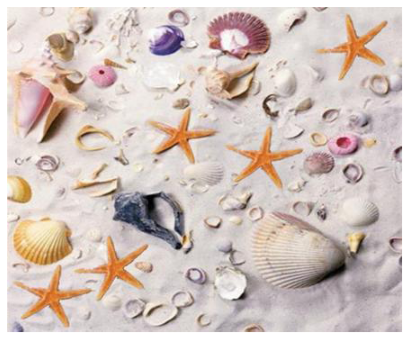

In [3]:
from skimage import io, img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

img = io.imread(os.path.join(GOOGLE_DRIVE_PATH, 'OnTheBeach.png'))

plt.figure(figsize=(9, 6)) 
plt.imshow(img)
plt.axis('off')
plt.show()

There are many ways to complete this task. A suggested algorithmic workflow is presented in the following image:

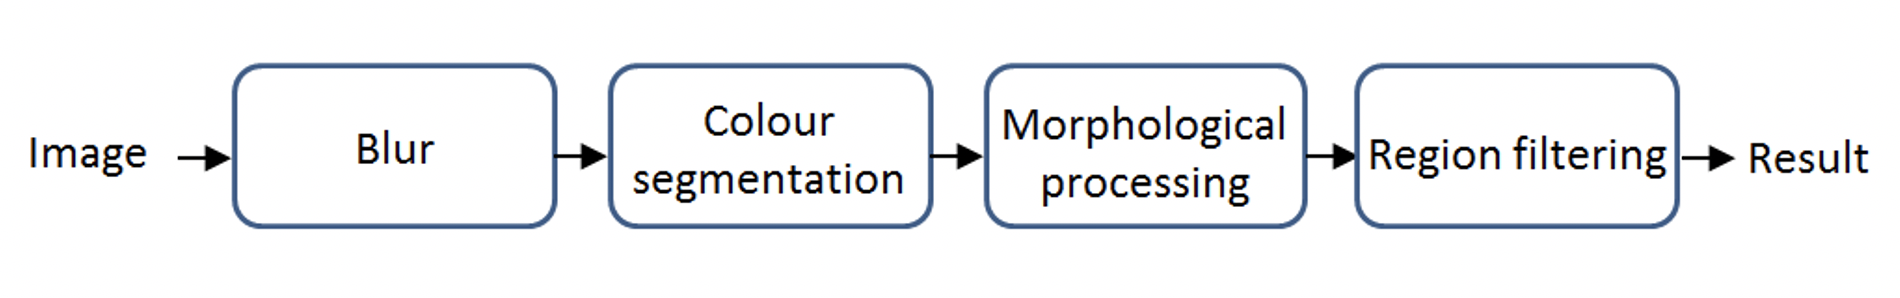

Let's now go through each step, so to understand the rationale behind it. Some of these steps will be presented to you as a task (i.e. you will have to find a possible implementation for them), while some others will be already solved. 

Make sure to **follow the suggested variable names** in order to keep the pipeline intact.

## Task 1.1: Blur

Images are corrupted by noise, which can be addressed using a denoising algorithm. A popular choice for denoising is blurring (a.k.a. low pass filtering), which reduces abrupt changes in image colour that is characteristic to noise. Whilst some blurring is often beneficial for image analysis, performing too much blurring can result in a loss of detail in the image. 

With this in mind, **blur the image by a small amount**. Feel free to use any type of low pass filter, like a box or Gaussian filter. Make sure to not blur it excessively! Then, display the result.

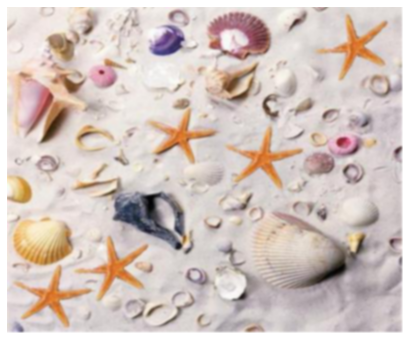

In [4]:
##############################################################################
# TODO: Blur the image                                                       #
##############################################################################
from skimage import filters

img_blur = img_as_ubyte(filters.gaussian(img, sigma=1, multichannel=True))

plt.figure(figsize=(9, 6))
plt.imshow(img_blur)
plt.axis('off')
plt.show()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

## Task 1.2: Colour segmentation

In this image, colour is one of the features that distinguishes the starfish from everything else in the image. As a consequence, **colour-based segmentation** seems like a very reasonable way forward.  This is like the thresholding we have seen in class, but applied with different values to each colour channel.  The result should be a binary image that has 1 for starfish-coloured pixels, and 0 for non-starfish coloured pixels. If you’re unsure how to do this, remember how you can use the logical operators (e.g. “&”) to combine different binary images.

What values should you use? In an interactive `matplotlib` environment, you could simply hover your mouse over the starfish to get an estimate for the proper ranges for this step. Since this is impossible in Colab, I have done this for you in advance. **Segment the image using the following channel-based ranges**: 

- $R>155$
- $100<G<180$
- $B<140$

Make sure to call the generated binary segmentation map `img_seg` and display it.

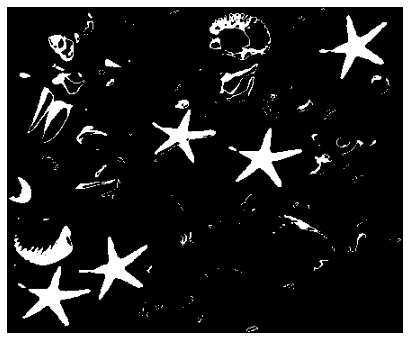

In [5]:
##############################################################################
# TODO: Perform colour-based thresholding                                    #
##############################################################################
img_seg = ((img_blur[:, :, 0] > 155) 
          & (img_blur[:, :, 1] > 100)
          & (img_blur[:, :, 1] < 180)
          & (img_blur[:, :, 2] < 140))

plt.figure(figsize=(9, 6))
plt.imshow(img_seg, cmap='gray')
plt.axis('off')
plt.show()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################


## Morphological processing

The boundaries of the segmented starfish should be reasonable, but there might be some holes in the starfish segmentations.  This can be easily addressed using morphological processing.  In fact, `scipy.ndimage` has a useful function called `binary_fill_holes` which can be used to **fill holes in a binary image** like this one:

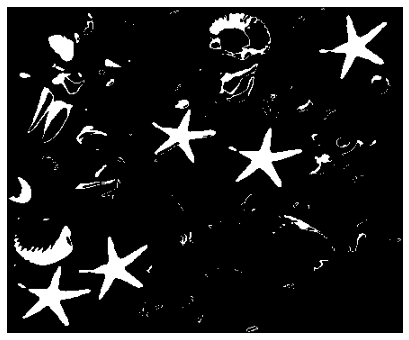

In [6]:
from scipy.ndimage import binary_fill_holes

im_filled = binary_fill_holes(img_as_float(img_seg))

plt.figure(figsize=(9, 6))
plt.imshow(im_filled, cmap='gray')
plt.axis('off')
plt.show()

## Region filtering

Most likely there is some clutter in your segmentation, with **non-starfish objects part of the segmentation mask**. The reason for this is that there are no single thresholds that uniquely identify starfish from non-starfish pixels in this image. Therefore, some additional processing is required in order to identify the starfish only.

Another feature that distinguishes starfish in the image is shape: starfish have a star shape! Not only that, the starfish are fairly large compared to the smaller shells and “clutter” that appears in the segmentation mask. So in the last stage of processing we will **apply a filter to remove regions that have incorrect shape characteristics or are too small**.

`skimage.measure` has a very useful function called [`regionprops`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) that computes basic shape characteristics for regions in image. The properties to compute must be set by the programmer as input arguments to this function. Examples include *area*,  *perimeter*, *solidity*, etc. – please see the documentation linked above for the full list. 

- The area of a region is approximated by the number of pixels in the region
- The perimeter is the number of pixels on the boundary of the region. The solidity is the number of pixels in the region’s segmentation mask divided by the number of pixels in the convex hull of the region
- The convex hull is the largest enclosing convex set that includes the region. An example is shown here, where the outline of the convex hull is shown in red. In 2D, the convex hull is a convex polygon.


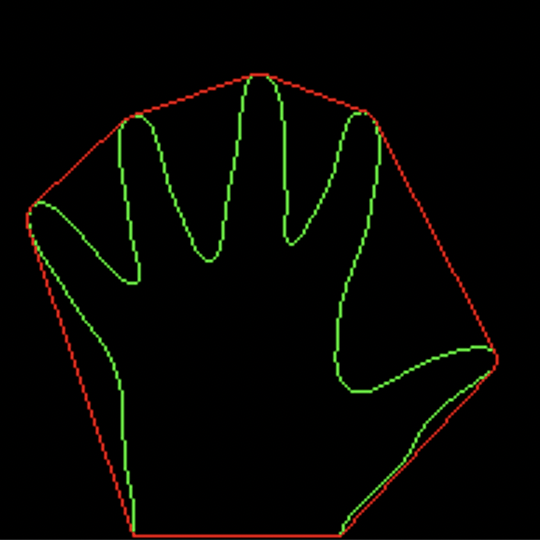

Therefore, a convex region will have a solidity of one, since all its pixels are in the convex hull.  However, a shape like a hand (or a starfish) will have a smaller percentage due to non-convexities in the shape.

With this in mind, let’s compute the region properties and filter regions to isolate the starfish regions. First, we will need to **label each separate object in the binary image**, since this is the type of input that regionprops accepts. This can be done with `skimage.measure.label`:

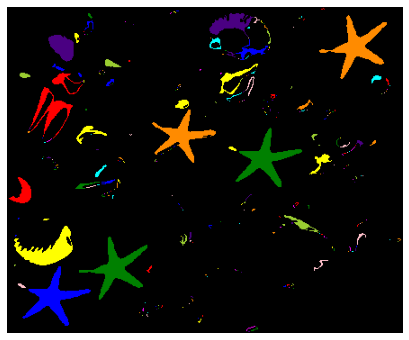

In [7]:
from skimage import measure, color

label_img = measure.label(im_filled)
label_img_rgb = color.label2rgb(label_img, bg_label=0)

plt.figure(figsize=(9, 6))
plt.imshow(label_img_rgb)
plt.axis('off')
plt.show()

Now, let's use regionprops to **filter the objects with an area greater than** 1000 pixels. Note that the following code might not be straightforward at first: spend some time to understand each command.

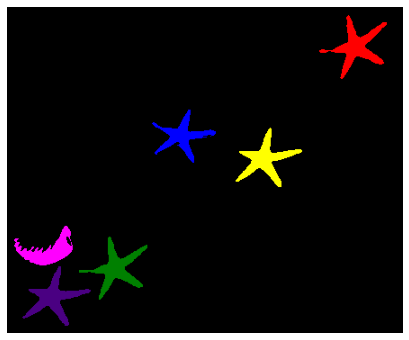

In [8]:
regions = measure.regionprops(label_img)

area_T = 1000
region_ids = [props.label for props in regions if props.area > area_T]

label_img_filtered = np.array([px if px in region_ids else 0 for px in label_img.ravel()])
label_img_filtered = label_img_filtered.reshape(label_img.shape)
label_img_filtered_rgb = color.label2rgb(label_img_filtered, bg_label=0)

plt.figure(figsize=(9, 6))
plt.imshow(label_img_filtered_rgb)
plt.axis('off')
plt.show()

Well, this is not bad! However, you are likely to still have some spurios objects (e.g. other shells) that were not filtered out. 

Can improve this result?

## Task 1.3: Improve region filtering

As said before, `regionprops` can estimate other useful metrics. Try to use some of them to **properly segment the starfish in the image** and display the obtained result.

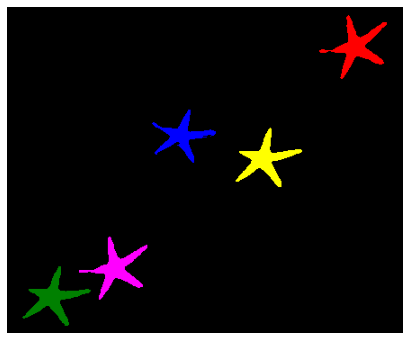

In [9]:
##############################################################################
# TODO: Improve region-based filtering                                       #
##############################################################################
area_T = 1000
solidity_T = 0.5
region_ids = [props.label for props in regions if (props.area > area_T) & (props.solidity < solidity_T)]

label_img_filtered = np.array([px if px in region_ids else 0 for px in label_img.ravel()])
label_img_filtered = label_img_filtered.reshape(label_img.shape)
label_img_filtered_rgb = color.label2rgb(label_img_filtered, bg_label=0)

plt.figure(figsize=(9, 6))
plt.imshow(label_img_filtered_rgb)
plt.axis('off')
plt.show()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Now that we have our final segmentation mask, we can also improve the visualisation using an overlay on the original image:

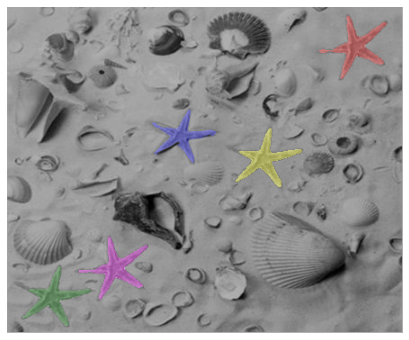

In [10]:
label_img_filtered_rgb = color.label2rgb(label_img_filtered, image=img, bg_label=0)

plt.figure(figsize=(9, 6))
plt.imshow(label_img_filtered_rgb)
plt.axis('off')
plt.show()

# 2: Finding starfish... with K-Means

In the lecture, we have seen how K-Means can be used to segment the image creating a clustering in colour-space. Let's see how it would work with the starfish image!

Img_reshaped shape = (159720, 3)


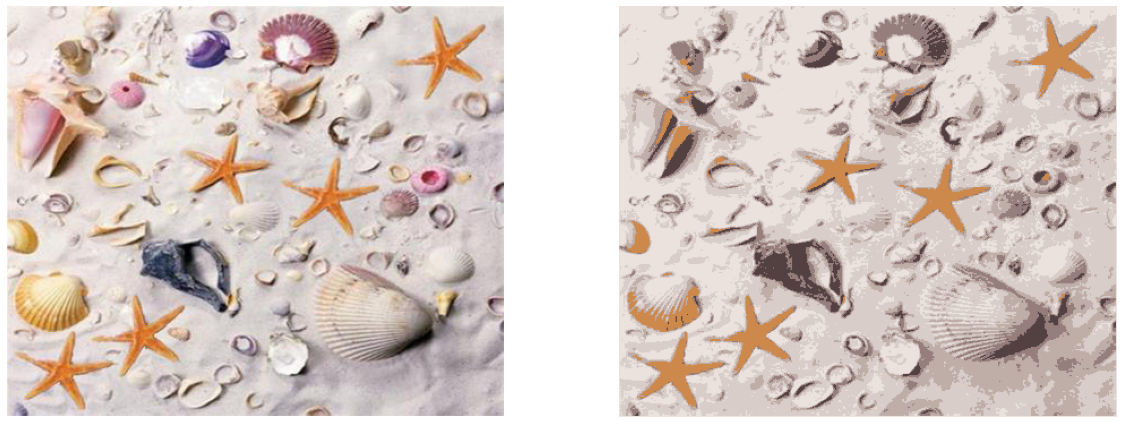

In [11]:
from sklearn.cluster import KMeans

img_reshaped = img_as_float(img).reshape((img.shape[0] * img.shape[1], 3))
print('Img_reshaped shape =', img_reshaped.shape)

n_colours = 6
kmeans = KMeans(n_clusters=n_colours, random_state=0).fit(img_reshaped)
labels = kmeans.predict(img_reshaped)

img_seg2 = kmeans.cluster_centers_[labels]
img_seg2 = img_as_ubyte(img_seg2.reshape(img.shape))

fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
ax[0].imshow(img), ax[0].axis('off')
ax[1].imshow(img_seg2), ax[1].axis('off')
fig.tight_layout()
plt.show()

# 3: How good is your segmentation?

As discussed in lecture, there are a variety of ways to determine the performance of a segmentation algorithm. A simple way is to compute a confusion matrix, and statistics like accuracy, sensitivity, and specificity.

In this week’s lab materials on Moodle you will find a ground truth mask, *groundTruth.png*. This mask indicates which pixels should be part of the correct segmentation, and which are not. 

Let's load it and compare it side-by-side with your segmentation mask:

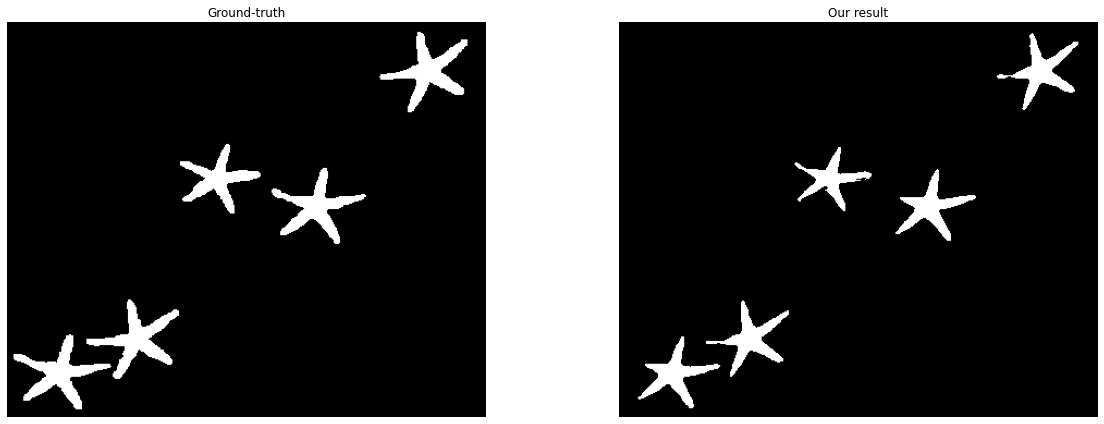

In [12]:
result = img_as_float(label_img_filtered > 0)
gt = io.imread(os.path.join(GOOGLE_DRIVE_PATH, 'GroundTruth.png'))
gt = img_as_float(color.rgb2gray(gt))

fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
ax[0].imshow(gt, cmap='gray')
ax[0].axis('off'), ax[0].set_title('Ground-truth')      
ax[1].imshow(result, cmap='gray')
ax[1].axis('off'), ax[1].set_title('Our result')
fig.tight_layout()
plt.show()

## Task 2.1: Computing classification-based metrics

Use this image to **compute the true positives, true negatives, false positives, and false negatives of your segmentation**. If you’re unsure about their definition, consult the lecture slides. 

Once you have these, **determine the accuracy, sensitivity, and specificity of your segmentation**.

In [13]:
##############################################################################
# TODO: Compute classification-based metrics                                 #
##############################################################################
result_ar = result.ravel()
gt_ar = gt.ravel()

TP = np.sum(np.logical_and(result_ar, gt_ar))
TN = np.sum(np.logical_and(1-result_ar, 1-gt_ar))
FP = np.sum(np.logical_and(result_ar, 1-gt_ar))
FN = np.sum(np.logical_and(1-result_ar, gt_ar))

SE = TP/(TP+FN)
SP = TN/(TN+FP)
ACC = (TP+TN)/(TP+TN+FP+FN)
print('Sensitivity = ',SE*100)
print('Specificity = ',SP*100)
print('Accuracy = ',ACC*100)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Sensitivity =  76.695777006819
Specificity =  99.97291244111759
Accuracy =  98.75469571750564


## Task 2.2: Computing the Dice-Sørensen Coefficient (DSC)

Another very important metric is the **DSC coefficient**. Compute it using the previously determined variables.

In [14]:
##############################################################################
# TODO: Compute DSC                                                          #
##############################################################################
DSC=2*TP/(2*TP+FP+FN)
print('Dice-Sørensen Coefficient = ',DSC*100)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Dice-Sørensen Coefficient =  86.57079197893458
